In [ ]:
using LinearAlgebra
using PolyChaos
using QuadGK
using Plots

sys_size = 2

function spectral_func(input::AbstractString, D::Float64, g::Float64)
    inband = x -> (-D <= x <= D)
        
    if input == "flat"
        J = x -> inband(x) ? 1/(2D) : 0.0
    elseif input == "elliptical"
        J = x -> inband(x) ? sqrt(1 - (x/D)^2) : 0.0
    elseif input == "ohmic"
        J = x -> inband(x) ? abs(x) : 0.0
    elseif input == "lorentzian"
        J = x -> 1/(1 + (x/D)^2)
    else
        error("spectral function type not recognized")
    end
    # normalization
    norm = quadgk(J, -D, D)[1]           
    Jnorm = x -> g*D/pi * J(x) / norm
    return Jnorm
end

function thermofield_transform(J, beta::Float64, mu::Float64) #spectral function, inverse temp, chemical potential
    """thermofield purification using fermi function ancilla"""
    fermi(k) = 1/(1 + exp(beta*k - beta*mu))
    J1 = w -> J(w) * fermi(w) #filled mode spectral density
    J2 = w -> J(w) * (1 - fermi(w)) #empty mode spectral density
    return J1, J2
end

function chain_map(J, N::Int64, D::Float64)
    """calculates family of monic orthogonal polynomials w.r.t the measure J(x) up to the Nth term.
    returns the coefficients alpha and beta from the recurrence relation of the family."""
    supp = (-D, D)
    meas = Measure("bath", J, supp, false, Dict())
    ortho_poly = OrthoPoly("bath_op", N, meas; Nquad=10000)   
    chain = coeffs(ortho_poly)                                  
    Es = chain[1:N,1] #site energies
    ts = sqrt.(chain[1:N,2]) #site hoppings (first term is system hopping)
    return Es, ts
end

function prepare_corrs(N, sys_occs; n_sites=sys_size)
    N_tot = 2N + n_sites
    C = zeros(ComplexF64, N_tot, N_tot)
    for n in 1:n_sites
        C[n,n] = sys_occs[n]
    end
    for n in 1:N
        C[n_sites + 2n - 1, n_sites + 2n - 1] = 1.0
        C[n_sites + 2n, n_sites + 2n] = 0.0
    end
    return C
end


function HamiltonianCorrs(N, H_sys, E1, t1, E2, t2; n_sites=sys_size)
    N_tot = 2N + n_sites
    H = zeros(ComplexF64, N_tot, N_tot)
    for n in 1:n_sites
        for m in 1:n_sites
            H[n,m] = H_sys[n,m]
        end
    end

    #nth system site coupling to bath
    H[n_sites,n_sites+1] = t1[1]
    H[n_sites+1,n_sites] = t1[1]
    H[n_sites,n_sites+2] = t2[1]
    H[n_sites+2,n_sites] = t2[1]

    for n in 1:N
        H[2n-1+n_sites, 2n-1+n_sites] = E1[n]
        H[2n+n_sites, 2n+n_sites] = E2[n]
    end
    for n in 2:N
        H[2n-1,2n+1] = t1[n]
        H[2n+1,2n-1] = t1[n]
        H[2n, 2n+2] = t2[n]
        H[2n+2, 2n] = t2[n]
    end
    return H
end

function evolve_corrs(C0, H, dt, tmax)
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im*t*H)
        C = U * C0 * U'
        push!(Cs, C)
    end
    return Cs
end

evolve_corrs (generic function with 1 method)

In [ ]:
#simulation params
N = 50
dt = 0.1
tmax = 80.0

#bath params
D = 1.0
g = 5.0
beta = 1000.0
mu = 0.0

#system params
sys_occs = [1.0, 0.0]
H_sys = [0.0 0.1; 0.1 0.0]
@assert issymmetric(H_sys) == true

J = spectral_func("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)

E1, t1 = chain_map(J1, N, D)
E2, t2 = chain_map(J2, N, D)

H = HamiltonianCorrs(N, H_sys, E1, t1, E2, t2)
C0 = prepare_corrs(N,sys_occs)
Cs = evolve_corrs(C0, H, dt, tmax)

801-element Vector{Array{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.9999003342592828 + 0.0im -2.8107101134324224e-7 + 0.009933212749636074im … -1.0574158698246973e-123 - 3.298490491221328e-123im 1.3655510051174207e-124 - 4.120687273106113e-124im; -2.8107101134324224e-7 - 0.009933212749636074im 0.008013180087560955 + 0.0im … 3.2825023835896637e-121 - 1.0523498946044021e-121im -3.306990777638404e-124 - 1.1534097243371683e-124im; … ; -1.0574158698246973e-123 + 3.298490491221328e-123im 3.2825023835896637e-121 + 1.0523498946044021e-121im … 0.9999999999999999 + 0.0im -4.902245106425323e-242 - 3.5029524210747103e-242im; 1.365551005117421e-124 + 4.120687273106114e-124im -3.306990777638404e-124 + 1.1534097243371685e-124im … -4.902245106425264e-242 + 3.502952421074715e-242im 1.53094588108325e-245 - 8.5646391716133

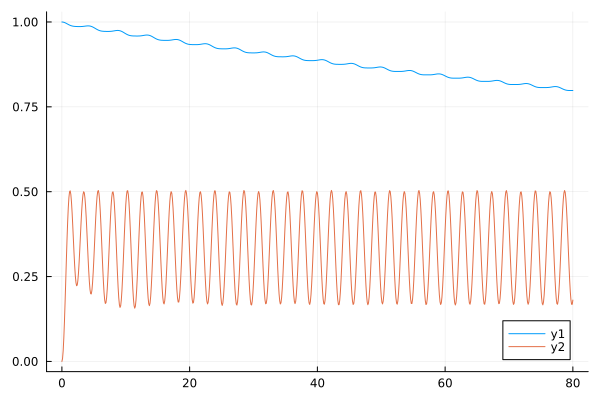

In [25]:
nSys1 = zeros(length(Cs))
nSys2 = zeros(length(Cs))
for (t,C) in enumerate(Cs)
    nSys1[t] = real(C[1,1])
    nSys2[t] = real(C[2,2])
end
gr() 

p = plot(0:dt:tmax, nSys1)
plot!(p, 0:dt:tmax, nSys2)

# Use gui() to force a window popup, or display(p) for standard output
display(p) 

In [ ]:
function find_rho(C; n_sites=sys_size)
    Csys = C[1:n_sites, 1:n_sites]
    zeta = clamp.(eigvals(Hermitian(Csys)), 0.0, 1.0)
    ρ_total = [1-zeta[1] 0.0; 
               0.0    zeta[1]]
    
    # 3. Iteratively apply the tensor product for the remaining modes
    for k in 2:length(zeta)
        ρ_k = [1-zeta[k] 0.0; 
               0.0    zeta[k]]
        ρ_total = kron(ρ_total, ρ_k)
    end
    
    return ρ_total
end

function trace_distance(ρ1, ρ2)
    # 1. Calculate the difference matrix
    diff = ρ1 - ρ2
    
    # 2. Get the eigenvalues of the difference matrix.
    # Since ρ1 and ρ2 are Hermitian, their difference is also Hermitian.
    # Using eigvals(Hermitian(...)) is numerically more stable and faster.
    λ = eigvals(Hermitian(diff))
    
    # 3. Sum the absolute values of the eigenvalues
    distance = 0.5 * sum(abs.(λ))
    
    return distance
end


trace_distance (generic function with 1 method)

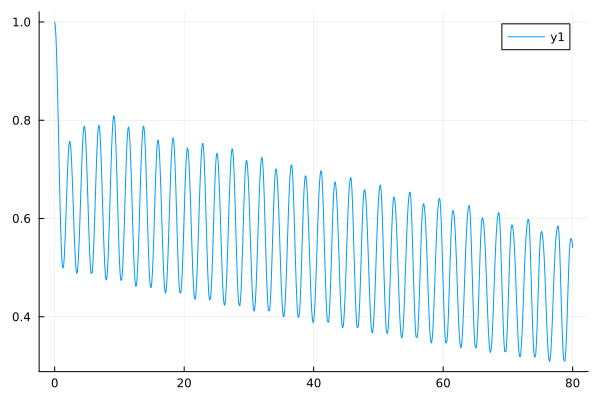

In [23]:
#C0_empty
sys_occs = [0.0, 0.0]
C0 = prepare_corrs(N,sys_occs)
Cs_empty = evolve_corrs(C0, H, dt, tmax)

#C0_full
sys_occs = [1.0, 0.0]
C0 = prepare_corrs(N,sys_occs)
Cs_full = evolve_corrs(C0, H, dt, tmax)

Ds = zeros(length(Cs_full))
for i in 1:length(Cs_full)
    C1 = Cs_full[i]
    rho1 = find_rho(C1)
    C2 = Cs_empty[i]
    rho2 = find_rho(C2)
    Ds[i] = trace_distance(rho1, rho2)
end

plot(0:dt:tmax, Ds)



 
